<a href="https://colab.research.google.com/github/nurialla2/Data4health/blob/main/Reto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asistente para identificar la cobertura de servicios de un paciente en su primera visita

In [ ]:
%pip install pandas
%pip install seaborn

In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


## 1. Preprocesado de datos

In [2]:
input_dir = "./data/input"
output_dir = "./data/output"

In [3]:
# Creamos los directorios (si no están ya creados)
%mkdir -p {input_dir}
%mkdir -p {output_dir}
# Descargamos los datos de input (si es necesario)
!wget -r -N -c -np https://physionet.org/files/eicu-crd-demo/2.0.1/
%mv physionet.org/files/eicu-crd-demo/2.0.1/* {input_dir}

--2022-06-30 10:58:51--  https://physionet.org/files/eicu-crd-demo/2.0.1/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/eicu-crd-demo/2.0.1/index.html’

physionet.org/files     [ <=>                ]   4.31K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-06-30 10:58:51 (376 MB/s) - ‘physionet.org/files/eicu-crd-demo/2.0.1/index.html’ saved [4416]

Loading robots.txt; please ignore errors.
--2022-06-30 10:58:51--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2022-06-30 10:58:51 (3.49 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

### 1.1 Selección de datos

In [4]:
df = pd.read_csv(f'{input_dir}/treatment.csv.gz', compression='gzip')
df

,treatmentid,patientunitstayid,treatmentoffset,treatmentstring,activeupondischarge
0,9579899,242895,838,cardiovascular|arrhythmias|anticoagulant admin...,False
1,8788989,242895,512,cardiovascular|consultations|Cardiology consul...,False
2,10293108,242895,838,cardiovascular|non-operative procedures|extern...,False
3,9017080,242895,70,pulmonary|vascular disorders|VTE prophylaxis|l...,False
4,9853526,242895,70,cardiovascular|consultations|Cardiology consul...,False
...,...,...,...,...,...
38285,82612510,3352230,2176,pulmonary|ventilation and oxygenation|mechanic...,False
38286,82477425,3352230,2176,neurologic|pain / agitation / altered mentatio...,False
38287,82402829,3352231,117,cardiovascular|non-operative procedures|intraa...,False
38288,82335549,3352333,317,gastrointestinal|consultations|Gastroenterolog...,False


In [5]:
treatmentList = df['treatmentstring'].tolist()
treatmentList2 = []
for treatment in treatmentList:
    for treat in treatment.split('|'):
        treatmentList2.append(treat)
repetitionsTreatment = Counter(treatmentList2)
sorted(repetitionsTreatment.items(), key=lambda x:x[1], reverse = True)

[('cardiovascular', 9606),
 ('pulmonary', 8409),
 ('medications', 7594),
 ('neurologic', 4667),
 ('gastrointestinal', 4474),
 ('ventilation and oxygenation', 3651),
 ('infectious diseases', 3465),
 ('pain / agitation / altered mentation', 2653),
 ('analgesics', 2322),
 ('consultations', 2296),
 ('renal', 2225),
 ('endocrine', 2192),
 ('therapeutic antibacterials', 1786),
 ('vascular disorders', 1773),
 ('myocardial ischemia / infarction', 1715),
 ('VTE prophylaxis', 1588),
 ('surgery', 1515),
 ('intravenous fluid', 1492),
 ('normal saline administration', 1381),
 ('mechanical ventilation', 1381),
 ('glucose metabolism', 1378),
 ('stress ulcer prophylaxis', 1328),
 ('insulin', 1270),
 ('radiologic procedures / bronchoscopy', 1194),
 ('electrolyte correction', 1190),
 ('shock', 1148),
 ('bronchodilator', 1099),
 ('arrhythmias', 1052),
 ('cultures / immuno-assays', 1036),
 ('cultures', 1019),
 ('sedative agent', 910),
 ('vasopressors', 896),
 ('non-operative procedures', 818),
 ('electrol

In [6]:
dfTreatment = df[df['treatmentstring'].str.contains("cardiovascular")]
dfTreatment = dfTreatment[['patientunitstayid','treatmentstring','activeupondischarge']]
dfTreatment

,patientunitstayid,treatmentstring,activeupondischarge
0,242895,cardiovascular|arrhythmias|anticoagulant admin...,False
1,242895,cardiovascular|consultations|Cardiology consul...,False
2,242895,cardiovascular|non-operative procedures|extern...,False
4,242895,cardiovascular|consultations|Cardiology consul...,False
6,242895,cardiovascular|consultations|Cardiology consul...,False
...,...,...,...
38276,3352230,cardiovascular|myocardial ischemia / infarctio...,False
38278,3352230,cardiovascular|shock|vasopressors|epinephrine ...,False
38281,3352230,cardiovascular|shock|inotropic agent|dobutamine,False
38283,3352230,cardiovascular|non-operative procedures|intraa...,False


In [7]:
listPatients = dfTreatment['patientunitstayid'].tolist()
repetitionsPatient = Counter(listPatients)
repetitionsPatient

Counter({242895: 17,
         243097: 16,
         243999: 3,
         244477: 3,
         244707: 5,
         246997: 3,
         247261: 3,
         249328: 37,
         249805: 15,
         250073: 1,
         250574: 3,
         250719: 12,
         250724: 30,
         251111: 6,
         257287: 14,
         257802: 7,
         258915: 20,
         260468: 21,
         260647: 10,
         260860: 3,
         261520: 22,
         262775: 3,
         263279: 5,
         263850: 54,
         264276: 42,
         264423: 3,
         264901: 21,
         267196: 1,
         267829: 2,
         272927: 1,
         275329: 6,
         276562: 6,
         276594: 2,
         276815: 9,
         280350: 18,
         281132: 14,
         282439: 6,
         284265: 22,
         284517: 1,
         287848: 3,
         288133: 8,
         289502: 2,
         291628: 3,
         292154: 5,
         294032: 14,
         295112: 1,
         295916: 18,
         296926: 4,
         296927: 13,


In [8]:
#Treatment: treatmentstring (obj)
#Patient: gender, age, apacheadmissiondx, admissionweight, admissionheight, ethnicity


In [9]:
dfDiagnosis = pd.read_csv(f'{input_dir}/diagnosis.csv.gz', compression='gzip', na_values="nan")
dfDiagnosis = dfDiagnosis.dropna()
#dfDiagnosis = dfDiagnosis[dfDiagnosis['diagnosisstring'].str.contains("cardiovascular")]
dfDiagnosis

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,7607199,346380,False,5028,cardiovascular|ventricular disorders|hypertension,"401.9, I10",Other
1,7570429,346380,False,685,neurologic|altered mental status / pain|change...,"780.09, R41.82",Major
2,7705483,346380,True,5035,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9",Major
3,7848601,346380,True,5035,neurologic|altered mental status / pain|schizo...,"295.90, F20.9",Major
4,7451475,346380,False,5028,pulmonary|disorders of vasculature|pulmonary e...,"415.19, I26.99",Major
...,...,...,...,...,...,...,...
24973,43897237,3158501,True,11,neurologic|altered mental status / pain|enceph...,"348.31, G93.41",Other
24974,44151864,3158501,True,11,hematology|white blood cell disorders|leukocyt...,"288.8, D72.829",Other
24975,44379558,3158501,True,11,pulmonary|disorders of acid base|respiratory a...,"276.2, E87.2",Other
24976,44000639,3158501,True,11,neurologic|altered mental status / pain|delirium,"293.0, F05",Other


In [10]:
listICDcodes = dfDiagnosis['icd9code'].tolist()
validIndices = []
i=0
for icd in listICDcodes:
    icdCode1 = icd.split(',')[0]
    if re.match(r'^-?\d+(?:\.\d+)$', icdCode1) is not None and float(icdCode1) >= 390 and float(icdCode1) <= 459:
        validIndices.append(i)
    i+=1

dfDiagnosisFiltered = dfDiagnosis.iloc[validIndices]
filteredPatientIds = set(dfDiagnosisFiltered['patientunitstayid'].tolist())

3351763 in filteredPatientIds

False

In [11]:
dfDiagnosis = pd.read_csv(f'{input_dir}/diagnosis.csv.gz', compression='gzip', na_values="nan")
dfDiagnosis = dfDiagnosis.dropna()

In [12]:
dfPatient = pd.read_csv(f'{input_dir}/patient.csv.gz', compression='gzip')
dfPatient

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,...,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,...,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,...,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,...,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,...,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,3351763,2741766,Female,62,Caucasian,459,1108,"Fistula/abscess, surgery for (not inflammatory...",165.1,16:08:00,...,Operating Room,1,admit,134.5,133.3,19:24:00,5394,Step-Down Unit (SDU),Alive,035-10391
2516,3352230,2742186,Male,41,African American,458,1107,"CABG alone, coronary artery bypass grafting",177.8,21:21:00,...,Operating Room,2,transfer,127.0,128.5,21:34:00,4261,Telemetry,Alive,035-10089
2517,3352231,2742186,Male,41,African American,458,1104,"Infarction, acute myocardial (MI)",177.8,21:21:00,...,Direct Admit,1,admit,127.0,135.2,22:26:00,1369,Other ICU,Alive,035-10089
2518,3352333,2742269,Male,72,Caucasian,458,1111,GI obstruction,177.8,20:00:00,...,Other Hospital,1,admit,68.3,66.5,17:26:00,4166,Floor,Alive,035-10041


In [13]:
dfPatientNew = dfPatient[['patientunitstayid', 'gender', 'age', 'admissionweight', 'admissionheight', 'ethnicity']]
dfPatientNew

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity
0,141764,Female,87,NaN,157.5,Caucasian
1,141765,Female,87,46.5,157.5,Caucasian
2,143870,Male,76,77.5,167.0,Caucasian
3,144815,Female,34,60.3,172.7,Caucasian
4,145427,Male,61,91.7,177.8,Caucasian
...,...,...,...,...,...,...
2515,3351763,Female,62,134.5,165.1,Caucasian
2516,3352230,Male,41,127.0,177.8,African American
2517,3352231,Male,41,127.0,177.8,African American
2518,3352333,Male,72,68.3,177.8,Caucasian


In [14]:
dfVitalAperiodic = pd.read_csv(f'{input_dir}/vitalAperiodic.csv.gz', compression='gzip')
dfVitalAperiodic

,vitalaperiodicid,patientunitstayid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
0,3661418,141764,81,171.0,90.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3661424,141764,334,153.0,78.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3661417,141764,77,176.0,87.0,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3661419,141764,165,173.0,106.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3661421,141764,255,182.0,103.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274083,445476282,3353113,2206,146.0,97.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274084,445476261,3353113,1269,121.0,87.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274085,445476252,3353113,710,127.0,89.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274086,445476260,3353113,1257,123.0,82.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
dfVitalAperiodic = dfVitalAperiodic.groupby(['patientunitstayid'], as_index=False).mean()[['patientunitstayid','vitalaperiodicid', 'observationoffset','noninvasivesystolic',
                                                                                           'noninvasivediastolic','noninvasivemean']]
dfVitalAperiodic

,patientunitstayid,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean
0,141764,3661420.5,204.125000,172.750000,93.375000,125.625000
1,141765,5600897.5,961.900000,146.033333,72.800000,98.400000
2,143870,5022024.5,296.500000,102.500000,53.166667,74.500000
3,144815,1196461.5,480.333333,114.388889,72.777778,88.777778
4,145427,2150246.5,358.250000,116.666667,62.833333,83.208333
...,...,...,...,...,...,...
2326,3351763,443446038.5,2876.161765,135.985294,63.323529,89.279412
2327,3352230,443136851.0,2360.507246,117.101449,65.260870,84.304348
2328,3352231,445040552.0,655.600000,128.000000,71.800000,91.800000
2329,3352333,442861118.5,1505.014286,146.600000,81.628571,106.228571


In [16]:
dfPatientNew = dfPatientNew.merge(dfVitalAperiodic, how='left', left_on='patientunitstayid', right_on='patientunitstayid')
dfPatientNew

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean
0,141764,Female,87,NaN,157.5,Caucasian,3661420.5,204.125000,172.750000,93.375000,125.625000
1,141765,Female,87,46.5,157.5,Caucasian,5600897.5,961.900000,146.033333,72.800000,98.400000
2,143870,Male,76,77.5,167.0,Caucasian,5022024.5,296.500000,102.500000,53.166667,74.500000
3,144815,Female,34,60.3,172.7,Caucasian,1196461.5,480.333333,114.388889,72.777778,88.777778
4,145427,Male,61,91.7,177.8,Caucasian,2150246.5,358.250000,116.666667,62.833333,83.208333
...,...,...,...,...,...,...,...,...,...,...,...
2515,3351763,Female,62,134.5,165.1,Caucasian,443446038.5,2876.161765,135.985294,63.323529,89.279412
2516,3352230,Male,41,127.0,177.8,African American,443136851.0,2360.507246,117.101449,65.260870,84.304348
2517,3352231,Male,41,127.0,177.8,African American,445040552.0,655.600000,128.000000,71.800000,91.800000
2518,3352333,Male,72,68.3,177.8,Caucasian,442861118.5,1505.014286,146.600000,81.628571,106.228571


In [17]:
dfPatientNew['cardioDiagnosis'] = dfPatientNew['patientunitstayid'].apply(lambda x : x in filteredPatientIds)
dfPatientNew

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,cardioDiagnosis
0,141764,Female,87,NaN,157.5,Caucasian,3661420.5,204.125000,172.750000,93.375000,125.625000,False
1,141765,Female,87,46.5,157.5,Caucasian,5600897.5,961.900000,146.033333,72.800000,98.400000,False
2,143870,Male,76,77.5,167.0,Caucasian,5022024.5,296.500000,102.500000,53.166667,74.500000,False
3,144815,Female,34,60.3,172.7,Caucasian,1196461.5,480.333333,114.388889,72.777778,88.777778,False
4,145427,Male,61,91.7,177.8,Caucasian,2150246.5,358.250000,116.666667,62.833333,83.208333,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,3351763,Female,62,134.5,165.1,Caucasian,443446038.5,2876.161765,135.985294,63.323529,89.279412,False
2516,3352230,Male,41,127.0,177.8,African American,443136851.0,2360.507246,117.101449,65.260870,84.304348,True
2517,3352231,Male,41,127.0,177.8,African American,445040552.0,655.600000,128.000000,71.800000,91.800000,True
2518,3352333,Male,72,68.3,177.8,Caucasian,442861118.5,1505.014286,146.600000,81.628571,106.228571,False


In [18]:
dfTreatment = pd.read_csv(f'{input_dir}/treatment.csv.gz', compression='gzip')[['patientunitstayid','treatmentstring']]
dfTreatment 

,patientunitstayid,treatmentstring
0,242895,cardiovascular|arrhythmias|anticoagulant admin...
1,242895,cardiovascular|consultations|Cardiology consul...
2,242895,cardiovascular|non-operative procedures|extern...
3,242895,pulmonary|vascular disorders|VTE prophylaxis|l...
4,242895,cardiovascular|consultations|Cardiology consul...
...,...,...
38285,3352230,pulmonary|ventilation and oxygenation|mechanic...
38286,3352230,neurologic|pain / agitation / altered mentatio...
38287,3352231,cardiovascular|non-operative procedures|intraa...
38288,3352333,gastrointestinal|consultations|Gastroenterolog...


In [19]:
dfTreatment = dfTreatment.groupby(['patientunitstayid'], as_index=False).agg({'treatmentstring': ' '.join})
dfTreatment['treated'] = np.where(dfTreatment['treatmentstring'].str.contains("cardiovascular"), 'True', 'False')
dfTreatment = dfTreatment[['patientunitstayid', 'treated']]
dfTreatment

,patientunitstayid,treated
0,242895,True
1,243097,True
2,243999,True
3,244477,True
4,244707,True
...,...,...
1905,3351763,True
1906,3352230,True
1907,3352231,True
1908,3352333,False


In [20]:
dfPatientNew = dfPatientNew.merge(dfTreatment, how='left', left_on='patientunitstayid', right_on='patientunitstayid')
dfPatientNew = dfPatientNew.dropna()
dfPatientNew

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,cardioDiagnosis,treated
181,242895,Male,80,101.2,170.18,Caucasian,15957733.0,1102.800000,136.371429,73.028571,87.857143,True,True
182,243097,Male,49,127.0,185.40,Caucasian,17382422.5,1191.789474,128.947368,77.815789,88.815789,True,True
183,243999,Female,70,98.4,157.50,Caucasian,11676875.0,806.041096,101.589041,55.520548,65.945205,True,True
184,244477,Female,55,113.7,165.10,Caucasian,16120409.0,197.000000,112.142857,60.285714,72.285714,False,True
186,246997,Male,62,50.1,172.70,Caucasian,18137589.0,733.131148,96.245902,66.819672,79.147541,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,3351763,Female,62,134.5,165.10,Caucasian,443446038.5,2876.161765,135.985294,63.323529,89.279412,False,True
2516,3352230,Male,41,127.0,177.80,African American,443136851.0,2360.507246,117.101449,65.260870,84.304348,True,True
2517,3352231,Male,41,127.0,177.80,African American,445040552.0,655.600000,128.000000,71.800000,91.800000,True,True
2518,3352333,Male,72,68.3,177.80,Caucasian,442861118.5,1505.014286,146.600000,81.628571,106.228571,False,False


In [21]:
dfPatientNew.to_csv(f'{output_dir}/patientData.csv', index=False)

\#TODO:
* Añadir tabla de `lab`:
  * Filtrar por offset de 0 a 1140 (primeras 24 horas)
* Añadir columnas:
  * `icd9code` y `diagnosispriority` (tabla de `diagnosis`) como categórica
* Eliminar:
  * observationoffset
  * vitalaperiodicid

### 1.2 Análisis exploratorio de los datos

In [23]:
target_var = "treated"

In [24]:
dfPatientNew.isna().sum()

patientunitstayid       0
gender                  0
age                     0
admissionweight         0
admissionheight         0
ethnicity               0
vitalaperiodicid        0
observationoffset       0
noninvasivesystolic     0
noninvasivediastolic    0
noninvasivemean         0
cardioDiagnosis         0
treated                 0
dtype: int64

No tenemos nulos ✅

In [25]:
dfPatientNew.dtypes

patientunitstayid         int64
gender                   object
age                      object
admissionweight         float64
admissionheight         float64
ethnicity                object
vitalaperiodicid        float64
observationoffset       float64
noninvasivesystolic     float64
noninvasivediastolic    float64
noninvasivemean         float64
cardioDiagnosis            bool
treated                  object
dtype: object

`treated` lo detecta como `object` en vez de como bool ❓❓

In [26]:
dfPatientNew.describe()

,patientunitstayid,admissionweight,admissionheight,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean
count,1.754000e+03,1754.000000,1754.000000,1.754000e+03,1754.000000,1754.000000,1754.000000,1754.000000
mean,1.861020e+06,83.323683,169.707155,2.557552e+08,1786.408157,120.965304,66.097153,81.769967
std,9.357033e+05,25.420818,17.559577,1.102441e+08,2669.252386,18.280148,11.208715,12.907953
min,2.428950e+05,32.700000,0.300000,8.459184e+06,-387.855072,49.454545,20.727273,28.181818
25%,1.070968e+06,65.770000,162.600000,1.677571e+08,553.808528,108.008893,58.405731,72.731501
50%,1.787226e+06,79.400000,170.200000,2.501745e+08,999.443328,119.100847,65.380050,80.105556
75%,2.734164e+06,96.575000,177.800000,3.468187e+08,1934.380201,132.569823,73.006579,90.108546
max,3.353113e+06,293.930000,600.000000,4.454763e+08,32124.688249,187.362712,119.444444,138.555556


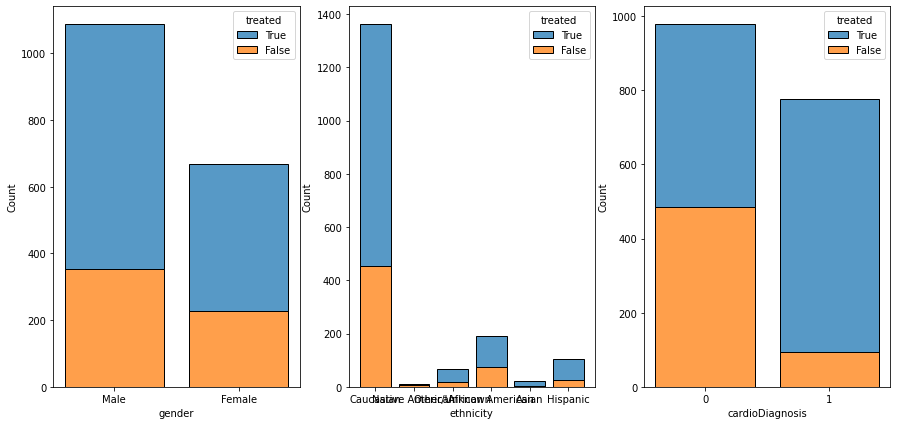

In [27]:
# Análisis de variables categóricas
categorical_vars = ("gender", "ethnicity", "cardioDiagnosis")
fig, ax = plt.subplots(nrows=1, ncols=len(categorical_vars), figsize=(15,7))
for i, var in enumerate(categorical_vars):
  sns.histplot(dfPatientNew, x=var, ax=ax[i], discrete=True, shrink=0.8, hue=target_var, multiple="stack")
  ax[i].set_xticks(sorted(dfPatientNew[var].unique()))

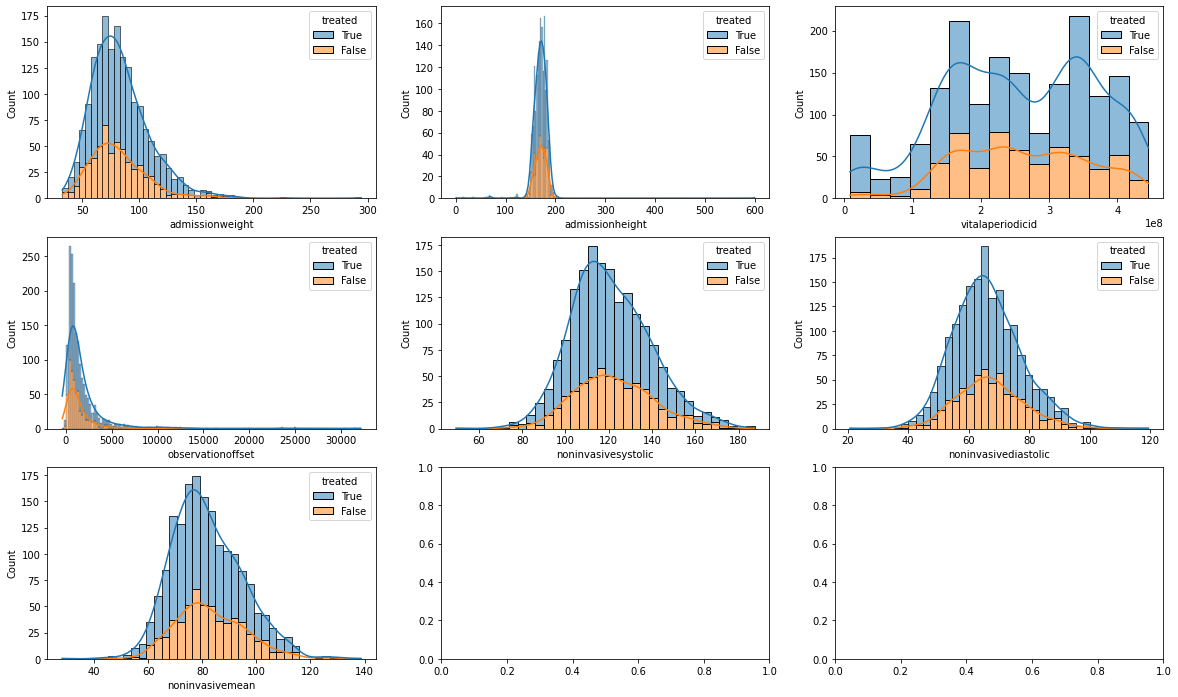

In [28]:
# Análisis de variables numéricas
numerical_vars = ("admissionweight", "admissionheight", "vitalaperiodicid", "observationoffset", "noninvasivesystolic", "noninvasivediastolic",	"noninvasivemean")
nrows=3
ncols=math.ceil(len(numerical_vars)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
for i, var in enumerate(numerical_vars):
  sns.histplot(dfPatientNew, x=var, ax=ax[i//ncols, i%ncols], kde=True, hue=target_var, multiple="stack")

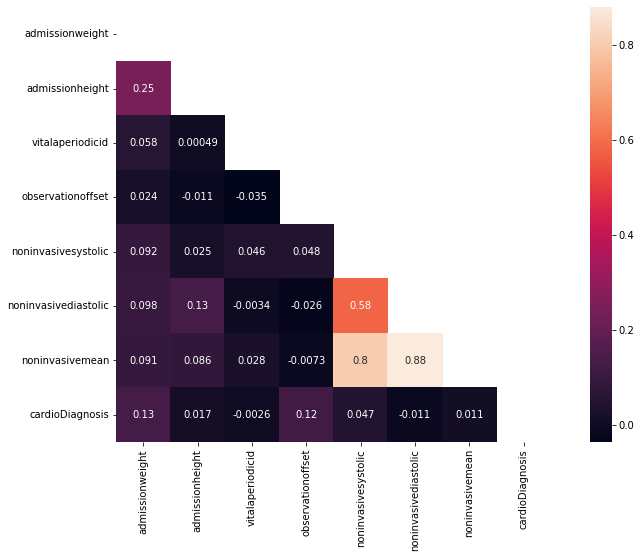

In [29]:
# Análisis de correlaciones
corr = dfPatientNew.drop("patientunitstayid", axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Esto es simplemente para mostras la mitad diagonal del heatmap
plt.figure(figsize=(14,8))
sns.heatmap(corr, square=True, mask=mask, annot=True)

Estas 3 variables tienen una distribución muy parecida y una correlación bastante alta entre ellas `noninvasivesystolic`,	`noninvasivediastolic`,	`noninvasivemean` 🚨

In [31]:
#TODO: pasar variables categóricas a hot-encodedn -> Solo si el modelo no acepta categóricas

## 2. Model selection

Modelos:
  * Random Forest or Decision Trees
  * Regresión logística o GAN

https://github.com/theonesp/ml_mort_cardiac/blob/master/analysis/training/training_models_full.ipynb


Explicabilidad:
  * Random forest: features importances, decision tree a secas
  * Regresión logística: odds-ratio -> https://www.researchgate.net/profile/Hilde-Van-De-Velde/publication/5461446/figure/fig1/AS:278659769356296@1443449074299/Forest-plot-for-the-diagnostic-odds-ratios-Circles-represent-individual-studies-The.png

Utilizar AUROC como valor de rendimiento